## **Modelling**

In [2]:
# Import necessary libraries
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import make_column_transformer, ColumnTransformer, TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold, cross_val_score
import numpy as np
import copy
import statsmodels.api as sm
from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import xgboost as xgb
from hyperopt import fmin, tpe, hp, anneal, Trials
from hyperopt import space_eval
from itertools import chain

In [2]:
# Import the dataset
df = pd.read_csv("wp_df.csv")

For the context of applying a machine learning model, we will have to encode categorical variables. By doing so in a pipeline, we come accross a problem: the encoder will only recognize classes that are present in the training set. The Real Estate sector classification was only created in 2016, meaning that the pipeline will not be able to properly encode it, when it starts observing stocks from that sector. Before 2016, firms in the Real Estate sector were classified as part of the "Financials" sector. Therefore, as a simple solution, we will uphold the classification at the beginning of the dataset, and pass all "Real Estate" sector companies as "Financials".

In [3]:
# Pass Real Estate sector as Financials
df.loc[df.gsector=='Real Estate', 'gsector'] = 'Financials'

In [4]:
# Define model sets of columns, X_cols are model features, y_col is the target, and then separate features into categorical and numerical
remove = ['vol', 'index_volatility', 'gvkey', 'datadate', 'tic', 'cusip', 'conm', 'mkt_cap', 'adj_price', 'ret', 'formation_month', 'total_market_cap', 'weight', 'weighted_return', 'vw_return']
X_cols = [col for col in list(df.columns) if col not in remove]
y_col = ['vol']
categorical_feats = ['gsector']
numerical_feats = [col for col in X_cols if col not in categorical_feats]

Create a function to detect outliers and replace them with the upper bound according to Tukey's range.

In [5]:
# Function to correct outliers wtihin pipeline
class OutlierFixer(BaseEstimator, TransformerMixin):

    def __init__(self, method='iqr', range=1.5):
        
        self.method = method
        self.range = range

    def fit(self, X, y=None):

        # Calculate the quartiles and interquartile range for each numerical column
        if self.method == 'iqr':
            self.q25_ = X.quantile(0.25)
            self.q75_ = X.quantile(0.75)
            self.iqr_ = self.q75_ - self.q25_

        return self

    def transform(self, X, y=None):
        
        # Apply outlier fixing
        if self.method == 'iqr':

            # Define the limits to search for outliers
            upper_lim = self.q75_ + self.range * self.iqr_
            lower_lim = self.q25_ - self.range * self.iqr_

            # Replace outliers with the specified limit value
            for col in X.columns:

                X.loc[X[col] > upper_lim[col], col] = upper_lim[col]
                X.loc[X[col] < lower_lim[col], col] = lower_lim[col]

        elif self.method == 'none':
            # Don't do anything to the outliers
            pass
    
        return X


In [9]:
# Define seed, cross-validation folds and model
random_state=42
kf = KFold(n_splits=5)

# Define the XGBoost model
regressor = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse', random_state=random_state)

# Build processor pipeline with outlier treatment, scaling, and encoding
numerical_transformer = Pipeline(steps=[
    ('outlier', OutlierFixer(method='none', range=2)),
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder())
])

processor = ColumnTransformer([
    ('numerical_transformer', numerical_transformer, numerical_feats),
    ('categorical_encoder', categorical_transformer, categorical_feats),
], remainder='drop')

# Build the full pipeline with named steps
pipeline = Pipeline([
    ('process', processor),
    ('regressor', regressor)
])


# Create a function to minimize
def objective(params, X, y, random_state=random_state, cv=kf):

    # Update preprocessor parameters
    processor.set_params(**{
        'numerical_transformer__outlier__method': params['process__numerical_transformer__outlier__method'],
        'numerical_transformer__outlier__range': params['process__numerical_transformer__outlier__range'],
        'numerical_transformer__scaler': params['process__numerical_transformer__scaler']
    })

    # Set pipeline parameters
    pipeline.set_params(process__numerical_transformer__outlier__method=str(params['process__numerical_transformer__outlier__method']),
                        process__numerical_transformer__outlier__range=params['process__numerical_transformer__outlier__range'],
                        process__numerical_transformer__scaler=params['process__numerical_transformer__scaler'],
                        regressor__max_depth=int(params['regressor__max_depth']),
                        regressor__gamma=params['regressor__gamma'],
                        regressor__subsample=params['regressor__subsample'],
                        regressor__colsample_bytree=params['regressor__colsample_bytree'],
                        regressor__eta=params['regressor__eta'],
                        regressor__alpha=params['regressor__alpha'],
                        regressor__lambda=params['regressor__lambda'])

    # Conduct the cross validation evaluation of model quality
    score = -cross_val_score(pipeline, X, y, cv=cv, scoring="neg_root_mean_squared_error", n_jobs=-1).mean()

    return score


# Define the search space for hyperparameters
space = {
    'process__numerical_transformer__outlier__method': hp.choice('process__numerical_transformer__outlier__method', ['none', 'iqr']),
    'process__numerical_transformer__outlier__range': hp.quniform('process__numerical_transformer__outlier__range', 1.25, 3.5, 0.25),
    'process__numerical_transformer__scaler': hp.choice('process__numerical_transformer__scaler', [RobustScaler(), StandardScaler(), MinMaxScaler()]),
    'regressor__max_depth': hp.quniform('regressor__max_depth', 2, 25, 1),
    'regressor__gamma': hp.quniform('regressor__gamma', 0, 0.2, 0.0005),
    'regressor__subsample': hp.quniform('regressor__subsample', 0.2, 1.0, 0.05),
    'regressor__colsample_bytree': hp.quniform('regressor__colsample_bytree', 0.2, 1.0, 0.05),
    'regressor__eta': hp.quniform('regressor__eta', 0.005, 0.25, 0.005),
    'regressor__alpha': hp.choice('regressor__alpha', [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 50, 100]),
    'regressor__lambda': hp.choice('regressor__lambda', [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 50, 100])
}

In [11]:
# Function to print optimal calculated hyperparameters
def print_pipeline_parameters(outlier_method, outlier_range, scaler, max_depth, gamma, subsample, colsample_bytree, eta, alpha, lambda_):

    print("-------------------------------")
    print("Pipeline Parameters: \n\n")
    print(f"Outlier method: {outlier_method}")
    print(f"Outlier range: {outlier_range}")
    print(f"Scaling method: {scaler}")
    print(f"Max Depth: {max_depth}")
    print(f"Gamma: {gamma}")
    print(f"Subsample: {subsample}")
    print(f"Colsample_bytree: {colsample_bytree}")
    print(f"ETA: {eta}")
    print(f"Alpha: {alpha}")
    print(f"Lambda: {lambda_}")
    print("-------------------------------")    

In [12]:
# Function to run model on a rolling basis, updating hyperparameters on parameterization_dates, and re-training the model according to the train_period 
def run_rolling_model(initial_separation_date, limit_separation_date, parameterization_dates, train_period=6):

    predictions = []

    # While date is not last date
    while initial_separation_date <= limit_separation_date:

        print("-----------------------------")
        print(f"Training period: 2000-01-01 - {initial_separation_date}")

        # Define end of test period as training period + defined train_period
        next_separation_date = (datetime.strptime(initial_separation_date, "%Y-%m-%d") + relativedelta(months=train_period)).strftime("%Y-%m-%d")
        print(f"Test period: {initial_separation_date} - {next_separation_date}")

        # Split train and test sets
        train = df[(df.datadate < initial_separation_date)]
        test = df[(df.datadate >= initial_separation_date) & (df.datadate < next_separation_date)]
        print("Train-Test sets separated")

        train_X, train_y = train[X_cols], train[y_col]
        test_X, test_y = test[X_cols], test[y_col]
        print("Datasets formed")

        # If date is to re-run hyperparameterization
        if initial_separation_date in parameterization_dates:

            print("- \nFinding optimal parameters according to training set")
            idx = parameterization_dates.index(initial_separation_date)

            # Advance initial date to train parameterization due to computationally expensive task
            train_parameters = df[(df.datadate >= str(pd.to_datetime("2000-01-01") + pd.DateOffset(months=(12*idx)))) & (df.datadate < initial_separation_date)]
            train__parameters_X, train_parameters_y = train_parameters[X_cols], train_parameters[y_col]

            print(f"Parameter tuning period: {(pd.to_datetime('2000-01-01') + pd.DateOffset(months=(12*idx))).strftime('%Y-%m-%d')} - {initial_separation_date}")

            # Find best parameters
            best = fmin(fn=lambda params: objective(params, train__parameters_X, train_parameters_y), space=space, algo=tpe.suggest, max_evals=50, rstate=np.random.RandomState(42))

            # Update preprocessor parameters
            processor.set_params(**{
                'numerical_transformer__outlier__method': ['none', 'iqr'][best['process__numerical_transformer__outlier__method']],
                'numerical_transformer__outlier__range': best['process__numerical_transformer__outlier__range'],
                'numerical_transformer__scaler': [RobustScaler(), StandardScaler(), MinMaxScaler()][best['process__numerical_transformer__scaler']]
            })

            # Update pipeline parameters
            pipeline.set_params(process__numerical_transformer__outlier__method = ['none', 'iqr'][best['process__numerical_transformer__outlier__method']],
                                process__numerical_transformer__outlier__range = best['process__numerical_transformer__outlier__range'],
                                process__numerical_transformer__scaler = [RobustScaler(), StandardScaler(), MinMaxScaler()][best['process__numerical_transformer__scaler']],
                                regressor__max_depth = int(best['regressor__max_depth']),
                                regressor__gamma = best['regressor__gamma'],
                                regressor__subsample = best['regressor__subsample'],
                                regressor__colsample_bytree = best['regressor__colsample_bytree'],
                                regressor__eta = best['regressor__eta'],
                                regressor__alpha = [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 50, 100][best['regressor__alpha']],
                                regressor__lambda = [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 50, 100][best['regressor__lambda']])
            
            # Print optimal hyperparameters found
            print_pipeline_parameters(['none', 'iqr'][best['process__numerical_transformer__outlier__method']], best['process__numerical_transformer__outlier__range'],
                                      [RobustScaler(), StandardScaler(), MinMaxScaler()][best['process__numerical_transformer__scaler']], int(best['regressor__max_depth']),
                                      best['regressor__gamma'], best['regressor__subsample'], best['regressor__colsample_bytree'], best['regressor__eta'],
                                      [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 50, 100][best['regressor__alpha']], [0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 50, 100][best['regressor__lambda']])
            

        # Fit pipeline
        pipeline.fit(train_X, train_y)
        print("Pipeline fitted")

        # Predict test set and append to predictions
        y_pred = pipeline.predict(test_X)
        print("Predictions calculated")
        predictions.append(y_pred)
        
        # Advance date to roll train and test sets
        initial_separation_date = next_separation_date

    return predictions

# Run the function and get predictions
predictions = run_rolling_model("2005-01-01", "2022-10-01", ["2005-01-01", "2008-01-01", "2011-01-01", "2014-01-01", "2017-01-01", "2020-01-01"], 3)

-----------------------------
Training period: 2000-01-01 - 2005-01-01
Test period: 2005-01-01 - 2005-04-01
Train-Test sets separated
Datasets formed
- 
Finding optimal parameters according to training set
Parameter tuning period: 2000-01-01 - 2005-01-01
100%|██████████| 50/50 [07:24<00:00,  8.90s/trial, best loss: 0.04873013456405746] 
-------------------------------
Pipeline Parameters: 


Outlier method: iqr
Outlier range: 3.0
Scaling method: MinMaxScaler()
Max Depth: 12
Gamma: 0.0325
Subsample: 0.5
Colsample_bytree: 0.8
ETA: 0.085
Alpha: 0.5
Lambda: 0.01
-------------------------------
Pipeline fitted
Predictions calculated
-----------------------------
Training period: 2000-01-01 - 2005-04-01
Test period: 2005-04-01 - 2005-07-01
Train-Test sets separated
Datasets formed
Pipeline fitted
Predictions calculated
-----------------------------
Training period: 2000-01-01 - 2005-07-01
Test period: 2005-07-01 - 2005-10-01
Train-Test sets separated
Datasets formed
Pipeline fitted
Predictio

In [ ]:
# Add obtained predictions to the test set
predictions2 = list(chain(*predictions))
test = df[df.datadate >= "2005-01-01"]
test['predicted_volatility'] = predictions2

In [3]:
# Save df with predictions
test.to_csv("predicted_df.csv", index=False)

----------------------------------------------------------------------------------------------------------------------------------------------

## **Model Evaluation**

In [4]:
from sklearn.metrics import max_error, mean_squared_error, mean_squared_log_error, r2_score
import warnings
warnings.filterwarnings("ignore")

# Calculate regression statistics
def regression_comparison(df, actual_col, comp_cols, index_labels):

    # Select relevant columns from the DataFrame
    data = df[comp_cols + [actual_col]]

    # Create a DataFrame to store the statistics
    statistics = pd.DataFrame()

    # Calculate and store each metric
    statistics['R-Squared'] = [r2_score(data[actual_col], data[pred_col]) for pred_col in comp_cols]
    statistics['Root Mean Squared Error'] = [mean_squared_error(data[actual_col], data[pred_col], squared=False) for pred_col in comp_cols]
    statistics['Mean Squared Log Error'] = [mean_squared_log_error(data[actual_col], data[pred_col]) for pred_col in comp_cols]
    statistics['Max Error'] = [max_error(data[actual_col], data[pred_col]) for pred_col in comp_cols]

    # Set the prediction column names as index
    statistics.index = index_labels

    return statistics

stats_reg = regression_comparison(test, "vol", ["predicted_volatility", "vol_1m"], ["Predicted Volatility", "Previous Month Volatility"])
stats_reg

,R-Squared,Root Mean Squared Error,Mean Squared Log Error,Max Error
Predicted Volatility,0.368569,0.045924,0.001525,1.377128
Previous Month Volatility,0.204454,0.051547,0.001802,2.831715


In [5]:
# Calculate rolling metrics
def rolling_performance(df, actual_col, comp_cols, index_labels, metric, rolling_months=60):

    comp_col1 = []
    comp_col2 = []
    dates = []
    df_dates = df.groupby('datadate').first().reset_index()['datadate']

    # For each month
    for month in range(0, len(df_dates)-rolling_months, 1):

        # Get dates
        init_date = df_dates.iloc[month]
        end_date = df_dates.iloc[month+(rolling_months)]

        # Subset period
        subset_df = df[(df.datadate >= init_date) & (df.datadate <= end_date)]
        # Calculate stats within period
        stats = regression_comparison(subset_df, actual_col, comp_cols, index_labels)
        # Append stats to each "predictor" list
        comp_col1.append(stats[metric][0])
        comp_col2.append(stats[metric][1])
        dates.append(subset_df['datadate'].iloc[0])
    
    return comp_col1, comp_col2, dates

# Get rolling R-Squared
rsq_data1, rsq_data2, dates = rolling_performance(test, "vol", ["predicted_volatility", "vol_1m"], ["Predicted Volatility", "Previous Month Volatility"], "R-Squared")
# Get rolling RMSE
rmse_data1, rmse_data2, dates = rolling_performance(test, "vol", ["predicted_volatility", "vol_1m"], ["Predicted Volatility", "Previous Month Volatility"], "Root Mean Squared Error")


In [6]:
# Plot rolling metrics
def plot_rolling_performance(data1, data2, dates, labels, cols, metric, rolling_months=60):

    plt.rcParams["figure.figsize"] = (15, 11)
    xticks = [(datetime.strptime(dates[i], "%Y-%m-%d").strftime("%Y-%m"), (datetime.strptime(dates[i], "%Y-%m-%d") + relativedelta(months=rolling_months)).strftime("%Y-%m")) for i in list(range(4, len(dates), 6))]

    # Plot for Set 1
    plt.plot(dates, data1, label=labels[0], color=cols[0])

    # Plot for Set 2
    plt.plot(dates, data2, label=labels[1], color=cols[1])

    if (metric == "R-Squared") or (metric == "Max Error"): plt.axhline(y=1, color='black', linestyle='--')
    else: plt.axhline(y=0, color='black', linestyle='--')

    # Add a legend and title to the plot
    plt.xticks(list(range(4, len(dates), 6)), [str(tick) for tick in xticks], rotation=60)
    plt.legend(prop={'size': 15})
    plt.title(f"Rolling {metric} Performance Comparison")

    # Show the plot
    plt.show()

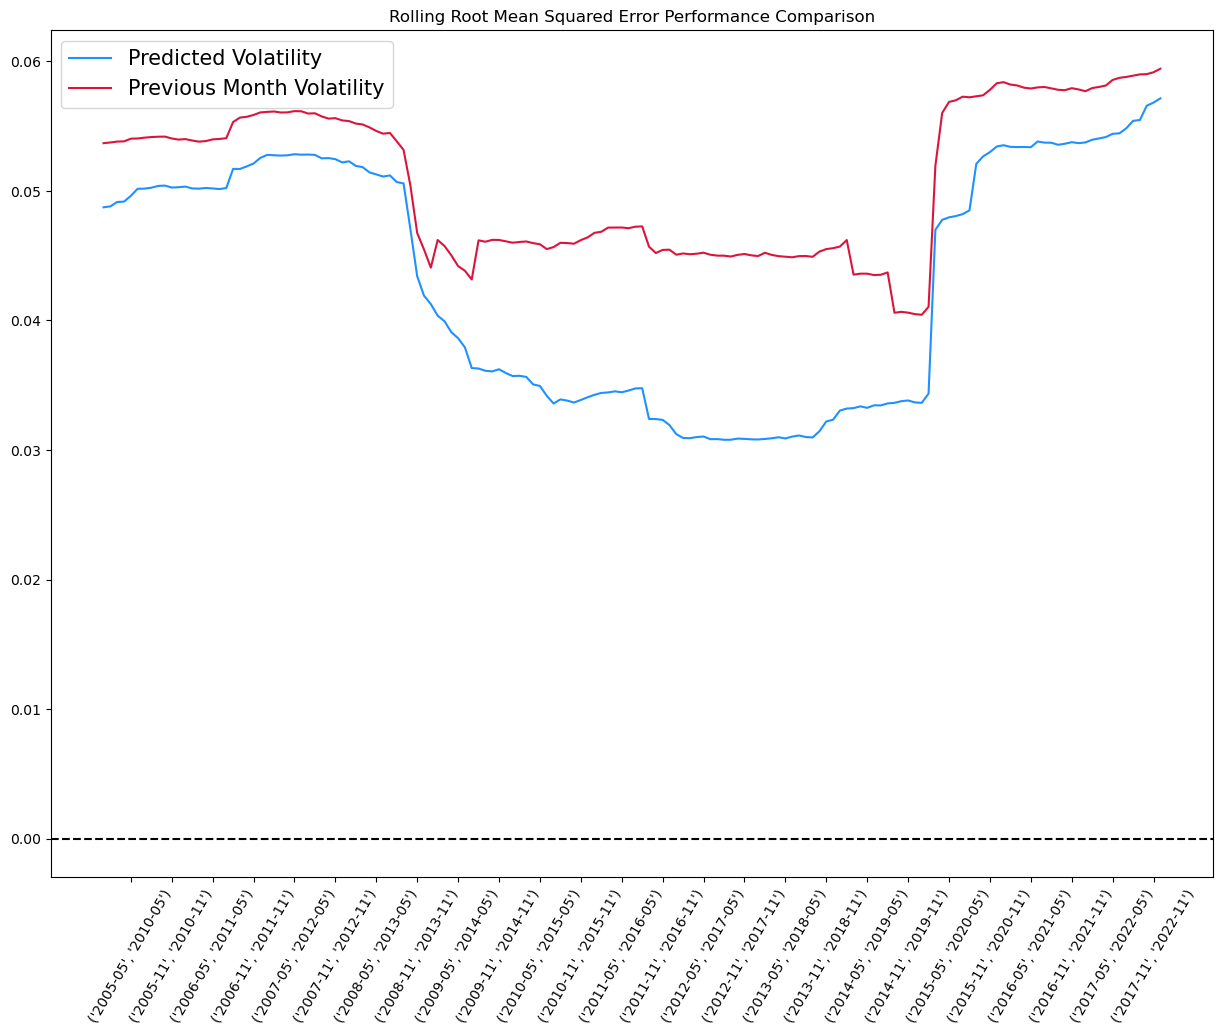

In [ ]:
# Rolling RMSE Performance
plot_rolling_performance(rmse_data1, rmse_data2, dates, ["Predicted Volatility", "Previous Month Volatility"], ["dodgerblue--","crimson"], "Root Mean Squared Error")

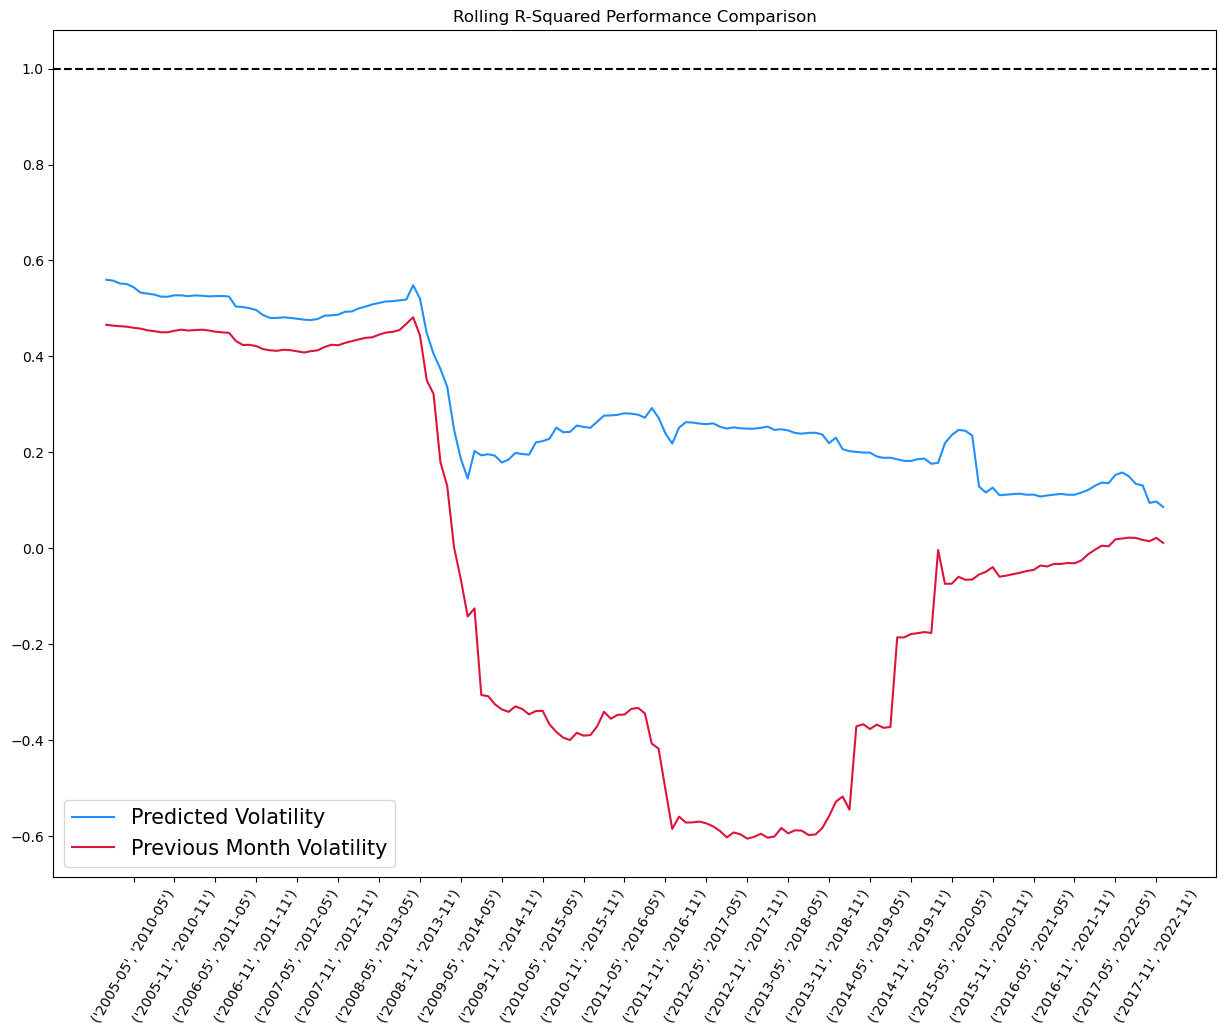

In [7]:
# Rolling R-Squared Performance
plot_rolling_performance(rsq_data1, rsq_data2, dates, ["Predicted Volatility", "Previous Month Volatility"], ["dodgerblue","crimson"], "R-Squared")

------------------------------------------------------------------